In [1]:
ownerpath = f'/Users/lenfn/Documents/AST 443/AST 443 Group 5'

In [2]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np
import sep

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.io import fits
from scipy.ndimage import shift

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Opening the dark frame files taken on lab 2 and getting the data
dark_frame = []
for i in range(10):
    filename = f'{ownerpath}/Lab 2/Darks/HAT_P_16_VISIBLE_DARK_20S_.0000000{i}.DARK.FIT'
    dark_f = fits.getdata(filename)
    dark_frame.append(dark_f)

In [4]:
#Turning the median of each dark frame into a master dark frame
master_dark_data = np.median(dark_frame, axis=0)

In [5]:
#Opening the dark frame files taken on lab 1 and getting the data
dark_frame_3 = []
for i in range(5):
    filename = f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Picture of Object/Andromena/Dark/Andromeda_Visible_Dark_3s_.0000000{i}.DARK.FIT'
    dark_f3 = fits.getdata(filename)
    dark_frame_3.append(dark_f3)

In [6]:
#Turning the median of each dark frame into a master dark frame
master_dark_data3 = np.median(dark_frame_3, axis=0)

In [10]:
#Opening the flat field files from lab one and getting the data
file_num=[1,2,3,4,5,6,7,8,9]
flat_fields_data=[]

for i in range(len(file_num)):
    field_file=f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_2s_visible_.0000000{i}.FLAT.FIT'
    field_file_data=fits.open(field_file)
    flat_fields_data.append(field_file_data[0].data)

# Computing the median flat field
median_flat_field = np.median(flat_fields_data, axis=0)

In [11]:
# Normalizing the flat field
master_flat_field=(median_flat_field-master_dark_data3)/np.max(median_flat_field)


In [12]:
#Opening the visible light files from our lab 2 observation

science_files = []

for i in range(194):
    if i < 10:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.0000000{i}.FIT'
    elif i < 100 :
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.000000{i}.FIT'
    else:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.00000{i}.FIT'
    science_data = fits.getdata(filename)
    science_files.append(science_data)

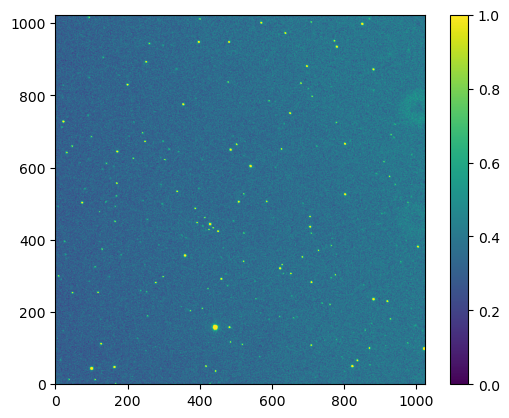

In [250]:

from astropy.visualization import ZScaleInterval

zscale=ZScaleInterval()
plt.imshow(zscale(calibrated_science_withflat[125]), origin='lower')
plt.colorbar()

In [15]:
#Calibrating each frame by subtracting the master dark and dividing it by the master flat 
calibrated_science_withflat = []
for i in range(194):
    science_corrected = (science_files[i] - master_dark_data)/master_flat_field
    calibrated_science_withflat.append(science_corrected)

#     output_file_with = f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(science_corrected)
#     hdu.writeto(output_file_with, overwrite=True)

array([[1345.69332444, 1368.35764497, 1359.65813157, ..., 1297.49245726,
        1263.66259498, 1293.23095285],
       [1348.69537826, 1351.12969048, 1354.98370037, ..., 1267.37389381,
        1347.2494828 , 1272.86460251],
       [1367.70918666, 1402.44134716, 1320.03145596, ..., 1282.21396479,
        1234.34721521, 1261.26487886],
       ...,
       [1213.72183195, 1208.37525286, 1237.64773966, ..., 1183.81336469,
        1090.68053257, 1211.218283  ],
       [1287.8709192 , 1204.60961352, 1202.1594897 , ..., 1114.47619004,
        1126.43474245, 1210.39943764],
       [1275.23694999, 1259.9271662 , 1207.12816894, ..., 1170.88344126,
        1162.06121018, 1149.96971092]])

In [16]:
mean, median, std = sigma_clipped_stats(calibrated_science_withflat[0], sigma=3.0)  
print(np.array((mean, median, std))) 

[252.68926402 252.56718088  15.30412704]


In [17]:
daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)  
sources = daofind(calibrated_science_withflat[0] - median)  
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  
sources.pprint(max_width=76)  
sources.write(f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/sources.txt', format='ascii', overwrite=True)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ----- -----
  1    307.29     17.53      0.91       0.09 ... 0.00  139.55  1.92 -0.71
  2    974.33     30.23      0.54       0.22 ... 0.00   63.25  1.38 -0.35
  3    453.31     35.35      0.82      -0.03 ... 0.00   97.06  1.48 -0.43
  4    488.44     40.14      0.55       0.31 ... 0.00   53.83  1.12 -0.12
  5    323.26     59.80      0.86       0.25 ... 0.00  131.94  1.98 -0.74
  6    435.31     77.48      0.94      -0.16 ... 0.00  164.67  2.30 -0.90
  7     39.27    167.40      0.76      -0.09 ... 0.00 2236.27 35.65 -3.88
  8      8.31    180.77      0.76      -0.28 ... 0.00   60.63  1.03 -0.04
  9    885.40    216.41      0.98      -0.02 ... 0.00 3044.05 39.92 -4.00
 10    934.33    219.34      0.97      -0.37 ... 0.00   97.89  1.27 -0.26
...       ...       ...       ...        ... ...  ...     ...   ...   ...
 58     85.99    892.53      0.60     

In [ ]:
# dir(DAOStarFinder)

In [115]:
def show_image(data, cmap='gray'):
    """
    Displays an image using the mean and standard deviation for contrast scaling.

    Parameters:
    - data: 2D numpy array, the image data to be displayed.
    - cmap: str, the colormap to be used for displaying the image (default is 'gray').

    Returns:
    - None
    """
    # Calculate the min and max values for display scaling
    mi = np.mean(data) - 4*np.std(data)
    ma = np.mean(data) + 2*np.std(data)
    
    # Display the image with the specified scaling
    plt.imshow(data, cmap=cmap, origin='lower', vmin=mi, vmax=ma)
    plt.colorbar()
    plt.show()

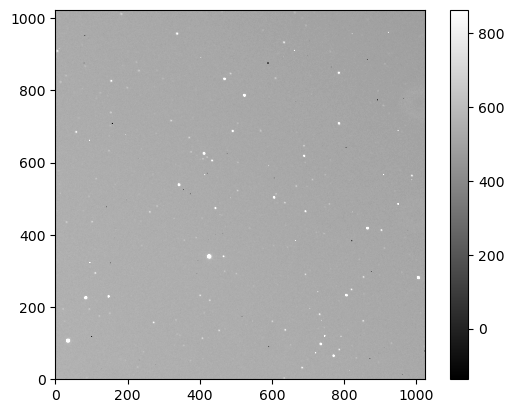

In [116]:
# norm = simple_norm(calibrated_science_withflat[0], 'sqrt')

# positions = np.transpose((493.338, 609.667))
# apertures = CircularAperture(positions, r=8.0)
# apertures.plot(color='red', lw=1.5, alpha=0.5)

show_image(calibrated_science_withflat[77])

In [27]:
good_frames=[]
for i in range(len(calibrated_science_withflat)):
        if np.mean(calibrated_science_withflat[i])<500:
            good_frames.append([calibrated_science_withflat[i]])

In [593]:
# positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
# apertures = CircularAperture(positions, r=5.0)
# norm = ImageNormalize(stretch=SqrtStretch())
# plt.imshow(calibrated_science_withflat[0], cmap='Greys', origin='lower', norm=norm,
#            interpolation='nearest')
# apertures.plot(color='blue', lw=1.5, alpha=0.5)
# plt.show()

In [ ]:
# ast = AstrometryNet()
# ast.api_key = 'zxdmyndauvanohii'

# sources = Table.read(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii')
# # Sort sources in ascending order
# sources.sort('flux')
# # Reverse to get descending order
# sources.reverse()

# image_width = 1024
# image_height = 1024
# wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
#                                         image_width, image_height, solve_timeout=120)

In [29]:
ast = AstrometryNet()
ast.api_key = 'kwbavttkhitkoaeo'

sources = Table.read(f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/sources.txt', format='ascii')
# Sort sources in ascending order
sources.sort('flux')
# Reverse to get descending order
sources.reverse()

image_width = 1024
image_height = 1024
wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                        image_width, image_height, solve_timeout=120)

Solving..................................

In [30]:
wcs_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        9.68152385727 / RA  of reference point                         
CRVAL2  =        42.4411100493 / DEC of reference point                         
CRPIX1  =             426.94

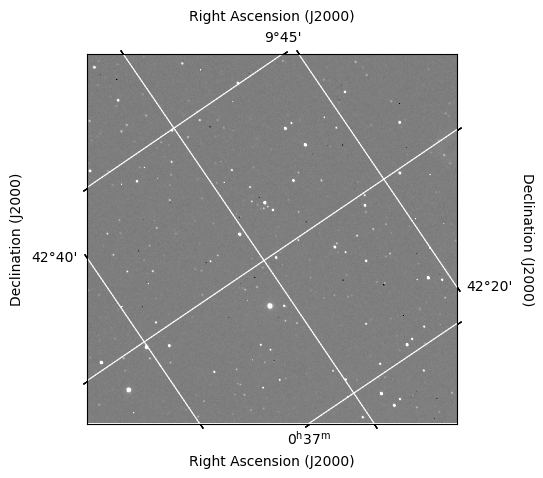

In [57]:
from astropy.wcs import WCS

# Load calibrated data
calibrated_data = calibrated_science_withflat[0]


# Create a WCS object using our wcs header
wcs = WCS(wcs_header)


# Create a plot with the WCS projection
ax = plt.subplot(projection=wcs, label='overlays')


# Display calibrated data
ax.imshow(calibrated_data, cmap='gray', vmax=np.mean(calibrated_data)+(np.std(calibrated_data)), vmin=np.mean(calibrated_data)-(np.std(calibrated_data)), origin='lower')

# Enable grid and set axis labels
ax.coords.grid(True, color='white', ls='solid')
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')



# Create an overlay coordinate system
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Right Ascension (J2000)')
overlay[1].set_axislabel('Declination (J2000)')



# Show the plot
plt.show()

In [32]:
aligned_num= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
    17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 33,
    36, 37, 38, 39, 40, 42, 43, 59, 63, 70, 71, 72, 74, 75,
    76, 82, 83, 84, 85, 86, 88, 89, 91, 92, 93, 94, 95, 96,
    97, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112,
    114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
    125, 126, 127]
aligned_images = []

for i in range(len(aligned_num)):
    aligned_file=f'{ownerpath}/Lab 2/Aligned Images/aligned_HAT_P_16_VISIBLE_LIGHT_20S_.{aligned_num[i]}.fits'
    aligned_file_data=fits.getdata(aligned_file)
    aligned_file_data = aligned_file_data.byteswap(inplace=True).newbyteorder()
    aligned_images.append(aligned_file_data)

In [34]:
# Define the cropping coordinates
x_min, x_max = 200, 800
y_min, y_max = 200, 800

#fig = plt.figure(figsize=(18, 3))  # width, height in inches
cropped_aligned_frames=[]

#Plot each flat frame
for i in range(len(aligned_images)):
        # Crop the image
    cropped_aligned_frames.append(aligned_images[i][y_min:y_max, x_min:x_max])

In [35]:
#remove background

cropped_bkgsub=[]
cbkg_rms=[]

for i in range(len(cropped_aligned_frames)):
    bkg = sep.Background(np.ascontiguousarray(cropped_aligned_frames[i]), bw=100, bh=100)
    cbkg_rms.append(bkg.globalrms)
    cropped_bkgsub.append(cropped_aligned_frames[i]-bkg)

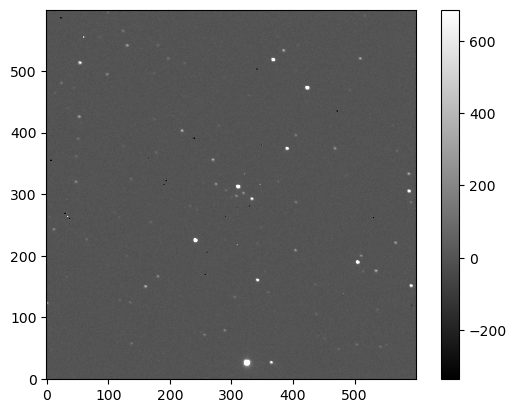

13.252641677856445


In [102]:
show_image(cropped_bkgsub[77])
print(cbkg_rms[55])

In [37]:
#extract objects from frame

frame_objects=[]
for i in range(len(cropped_bkgsub)):
    objects = sep.extract(cropped_bkgsub[i], 12, err=cbkg_rms[i])
    frame_objects.append(objects)

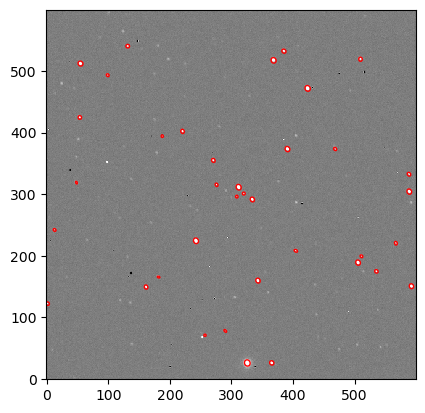

In [38]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(cropped_bkgsub[18]), np.std(cropped_bkgsub[18])
im = ax.imshow(cropped_bkgsub[18], interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(frame_objects[18])):
    e = Ellipse(xy=(frame_objects[18]['x'][i], frame_objects[18]['y'][i]),
                width=6*frame_objects[18]['a'][i],
                height=6*frame_objects[18]['b'][i],
                angle=frame_objects[18]['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [39]:
#Extract flux and flux error

fluxes=[]
flux_err=[]
flags=[]

for i in range(len(cropped_bkgsub)):
    flux, fluxerr, flag = sep.sum_circle(cropped_bkgsub[i], frame_objects[i]['x'], frame_objects[i]['y'],
                                     6.6, err=cbkg_rms[i], gain=2.0)
    fluxes.append(flux)
    flux_err.append(fluxerr)
    flags.append(flag)

In [40]:


def extract_flux_table(frame_objects, fluxes, flux_err, x_min, x_max, y_min, y_max):
    """
    Extracts the flux and flux error of objects within a specified pixel range and stores them in a table.

    Parameters:
    - frame_objects: list of dictionaries, where each dictionary contains 'x' and 'y' coordinates of objects in a frame.
    - fluxes: list of lists, where each sublist contains flux values for objects in a frame.
    - flux_err: list of lists, where each sublist contains flux error values for objects in a frame.
    - x_min: int, the minimum x-coordinate range.
    - x_max: int, the maximum x-coordinate range.
    - y_min: int, the minimum y-coordinate range.
    - y_max: int, the maximum y-coordinate range.

    Returns:
    - table: Astropy Table containing columns 'frame', 'x', 'y', 'flux', and 'flux_err'.
    """
    # Define lists to store the data
    frame_list = []
    x_list = []
    y_list = []
    flux_list = []
    flux_err_list = []

    # Iterate through each frame and each object's coordinates
    for i in range(len(fluxes)):
        for j in range(len(fluxes[i])):
            # Check if the object's coordinates are within the specified range
            x = frame_objects[i]['x'][j]
            y = frame_objects[i]['y'][j]
            if x_min < x < x_max and y_min < y < y_max:
                # Append the data to respective lists
                frame_list.append(i)
                x_list.append(x)
                y_list.append(y)
                flux_list.append(fluxes[i][j])
                flux_err_list.append(flux_err[i][j])

    # Create a table with the gathered data
    table = Table([frame_list, x_list, y_list, flux_list, flux_err_list], 
                  names=('frame', 'x', 'y', 'flux', 'flux_err'))

    return table

In [42]:
host_planet= extract_flux_table(frame_objects, fluxes, flux_err, 309, 320, 309, 315)
reference_star_1= extract_flux_table(frame_objects, fluxes, flux_err, 362, 374, 24, 28)
reference_star_2= extract_flux_table(frame_objects, fluxes, flux_err, 340, 352, 158, 162)
reference_star_3= extract_flux_table(frame_objects, fluxes, flux_err, 503, 514, 187, 191)
reference_star_4= extract_flux_table(frame_objects, fluxes, flux_err, 240, 251, 222, 226)
reference_star_5= extract_flux_table(frame_objects, fluxes, flux_err, 332, 344, 289, 293)
reference_star_6= extract_flux_table(frame_objects, fluxes, flux_err, 586, 598, 302, 306)
reference_star_7= extract_flux_table(frame_objects, fluxes, flux_err, 388, 400, 371, 375)
reference_star_8= extract_flux_table(frame_objects, fluxes, flux_err, 420, 432, 470, 474)
reference_star_9= extract_flux_table(frame_objects, fluxes, flux_err, 53, 64, 510, 514)
reference_star_10= extract_flux_table(frame_objects, fluxes, flux_err, 366, 378, 515, 519)
nofr=10

(0.2, 0.25)

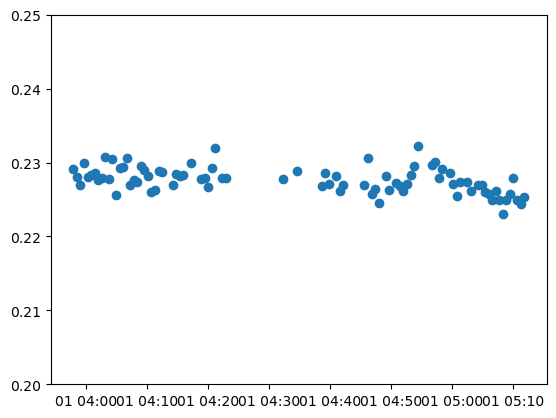

In [242]:
test = host_planet['flux'] / (reference_star_1['flux'] + reference_star_2['flux'] + reference_star_3['flux'] + reference_star_4['flux'] + reference_star_5['flux'] + reference_star_6['flux'] + reference_star_7['flux'] + reference_star_8['flux'] + reference_star_9['flux'] + reference_star_10['flux'])
plt.scatter(times, test)
plt.ylim(0.20, 0.25)

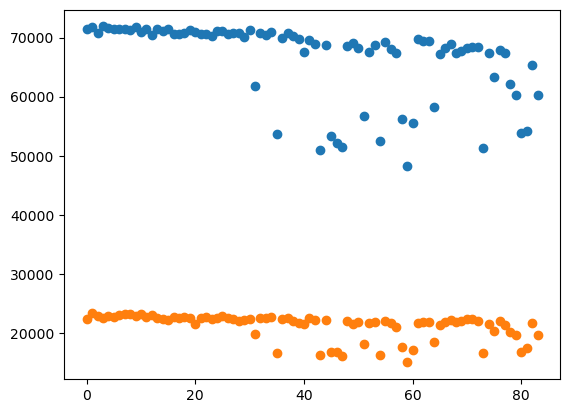

In [228]:
plt.scatter(np.arange(len(fluxes)), host_planet['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_1['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_2['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_3['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_4['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_5['flux'])
plt.scatter(np.arange(len(fluxes)), reference_star_6['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_7['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_8['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_9['flux'])
# plt.scatter(np.arange(len(fluxes)), reference_star_10['flux'])
# # plt.scatter(np.arange(len(fluxes)), reference_star_11['flux'])

In [44]:
from datetime import datetime
import matplotlib.dates as mdates

# List of frame times in UT (as strings)
frame_times_ut = [
    "03:57:55", "03:58:30", "03:59:05", "03:59:40", "04:00:15", "04:00:50",
    "04:01:25", "04:01:59", "04:02:35", "04:03:10", "04:03:45", "04:04:20",
    "04:04:55", "04:05:30", "04:06:05", "04:06:40", "04:07:15", "04:07:49",
    "04:08:24", "04:08:59", "04:09:34", "04:10:09", "04:10:44", "04:11:19",
    "04:11:54", "04:12:29", "04:14:13", "04:14:48", "04:15:23", "04:15:58",
    "04:17:08", "04:18:52", "04:19:27", "04:20:02", "04:20:37", "04:21:12",
    "04:22:22", "04:22:57", "04:32:15", "04:34:35", "04:38:39", "04:39:14",
    "04:39:49", "04:40:59", "04:41:33", "04:42:08", "04:45:38", "04:46:13",
    "04:46:48", "04:47:22", "04:47:57", "04:49:07", "04:49:42", "04:50:52",
    "04:51:27", "04:52:01", "04:52:36", "04:53:11", "04:53:46", "04:54:21",
    "04:56:41", "04:57:15", "04:57:50", "04:58:25", "04:59:35", "05:00:10",
    "05:00:45", "05:01:20", "05:02:29", "05:03:04", "05:04:14", "05:04:49",
    "05:05:24", "05:05:59", "05:06:34", "05:07:09", "05:07:43", "05:08:18",
    "05:08:53", "05:09:28", "05:10:03", "05:10:38", "05:11:13", "05:11:48"
]

# Convert times to datetime objects
times = [datetime.strptime(t, "%H:%M:%S") for t in frame_times_ut]



In [151]:
star_0= extract_flux_table(frame_objects, fluxes, flux_err, 309, 320, 309, 315)
star_1= extract_flux_table(frame_objects, fluxes, flux_err, 362, 374, 24, 28)
star_2= extract_flux_table(frame_objects, fluxes, flux_err, 340, 352, 158, 162)
star_3= extract_flux_table(frame_objects, fluxes, flux_err, 503, 514, 187, 191)
star_4= extract_flux_table(frame_objects, fluxes, flux_err, 240, 251, 222, 226)
star_5= extract_flux_table(frame_objects, fluxes, flux_err, 332, 344, 289, 293)
star_6= extract_flux_table(frame_objects, fluxes, flux_err, 586, 598, 302, 306)
star_7= extract_flux_table(frame_objects, fluxes, flux_err, 388, 400, 371, 375)
#star_8= extract_flux_table(frame_objects, fluxes, flux_err, 420, 432, 470, 474)
star_9= extract_flux_table(frame_objects, fluxes, flux_err, 53, 64, 510, 514)
#star_10= extract_flux_table(frame_objects, fluxes, flux_err, 366, 378, 515, 519)

In [152]:
star_fluxes=np.array([star_0['flux'], star_1['flux'], star_2['flux'], star_3['flux'], star_4['flux'],
             star_5['flux'], star_6['flux'], star_7['flux'], 
                      #star_8['flux'], 
                      star_9['flux'], 
                      #star_10['flux']
                     ])

star_fluxes_err=np.array([star_0['flux_err'], star_1['flux_err'], star_2['flux_err'], star_3['flux_err'], star_4['flux_err'],
             star_5['flux_err'], star_6['flux_err'], star_7['flux_err'], 
                          #star_8['flux_err'], 
                          star_9['flux_err'], 
                          #star_10['flux_err']
                         ])

In [211]:
starref_fluxes=np.array([#star_0['flux'], 
                         star_1['flux'], star_2['flux'], star_3['flux'], star_4['flux'],
                         star_5['flux'], star_6['flux'], star_7['flux'], 
                      #star_8['flux'], 
                      star_9['flux'], 
                      #star_10['flux']
                     ])

starref_fluxes_err=np.array([#star_0['flux_err'], 
                             star_1['flux_err'], star_2['flux_err'], star_3['flux_err'], star_4['flux_err'],
                             star_5['flux_err'], star_6['flux_err'], star_7['flux_err'], 
                          #star_8['flux_err'], 
                          star_9['flux_err'], 
                          #star_10['flux_err']
                         ])

In [153]:
def star_flux_ratio(main_star, main_star_err, star_fluxes, star_fluxes_err):
    

    rescale_main=main_star/np.average(main_star)
    rescale_main_err=main_star_err/np.average(main_star)
    
    ref_flux = []
    ref_flux_err = []
    average_flux = []
    rescale_flux = []
    rescale_flux_err = []
    weighted_flux = []
    weighted_flux_err = []
    num = []
    dem = []
    main_flux_r = []
    j=0
    
    for k in range(len(star_fluxes)):
        if star_fluxes[k][0]==main_star[0]:
            continue
        average_flux.append(np.average(star_fluxes[k]))
        ref_flux.append(star_fluxes[k])
        ref_flux_err.append(star_fluxes_err[k])
        
    while j < len(average_flux):
        rescale_flux.append(ref_flux[j]/average_flux[j])
        rescale_flux_err.append(ref_flux_err[j]/average_flux[j])
        j+=1
    j=0
    while j < len(rescale_flux[0]):
        a=0.0
        b=0.0
        for i in range(len(rescale_flux)):
            a += rescale_flux[i][j]/((rescale_flux_err[i][j])**2)
            b += 1/((rescale_flux_err[i][j])**2)
        num.append(a)
        dem.append(b)
        j+=1
    j=0
    while j < len(rescale_flux[0]):
        weighted_flux.append(num[j]/dem[j])
        weighted_flux_err.append(math.sqrt(1/dem[j]))
        j+=1
    j=0
    for j in range(len(weighted_flux)):
        main_flux_r.append(rescale_main[j]/weighted_flux[j])
    
    norm_r = main_flux_r/np.mean(main_flux_r[:37])
    norm_r_err = rescale_main_err/np.mean(main_flux_r[:37])
    
    return norm_r, norm_r_err

In [247]:
star, star_err= star_flux_ratio(star_fluxes[0], star_fluxes_err[0], star_fluxes, star_fluxes_err)

the difference ε is 0.019061
the difference ε error is -0.000016


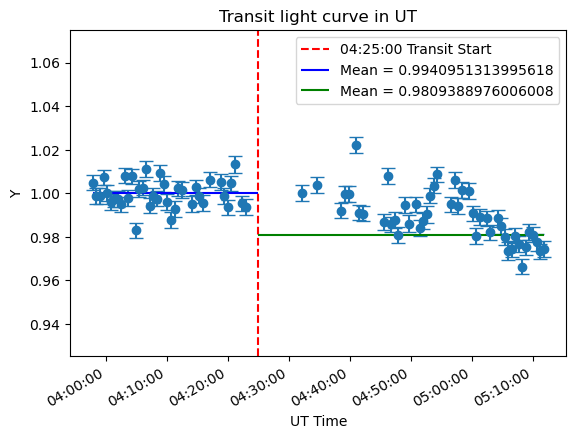

In [248]:
times_ut = [datetime.strptime(t, "%H:%M:%S") for t in frame_times_ut]

#set the target time as "04:25:00"
target_time = datetime.strptime("04:25:00", "%H:%M:%S") 

# print(f'the mean value before the transit is {mean1_nor:.6f}')
# print(f'the mean value during the transit is {mean2_nor:.6f}')
print(f'the difference \u03B5 is {np.mean(star[:37])-np.mean(star[64:]):.6f}')
print(f'the difference \u03B5 error is {np.mean(star_err[:37])-np.mean(star_err[64:]):.6f}')

plt.errorbar(times_ut, star, yerr=star_err, fmt='o', capsize=5)
plt.ylim(0.925, 1.075)
plt.xlabel('UT Time')
plt.ylabel('Y')
plt.title('Transit light curve in UT')


plt.axvline(target_time, color='r', linestyle='--', label='04:25:00 Transit Start')
#line of mean value before the transit
plt.hlines(np.mean(star[:37]), xmin=times_ut[0], xmax=target_time, color='blue', linestyle='-', label=f'Mean = {np.mean(star)}')
#line of mean value during the transit
plt.hlines(np.mean(star[64:]), xmin=target_time, xmax=times_ut[-1], color='green', linestyle='-', label=f'Mean = {np.mean(star[64:])}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

-0.0003629191799635362


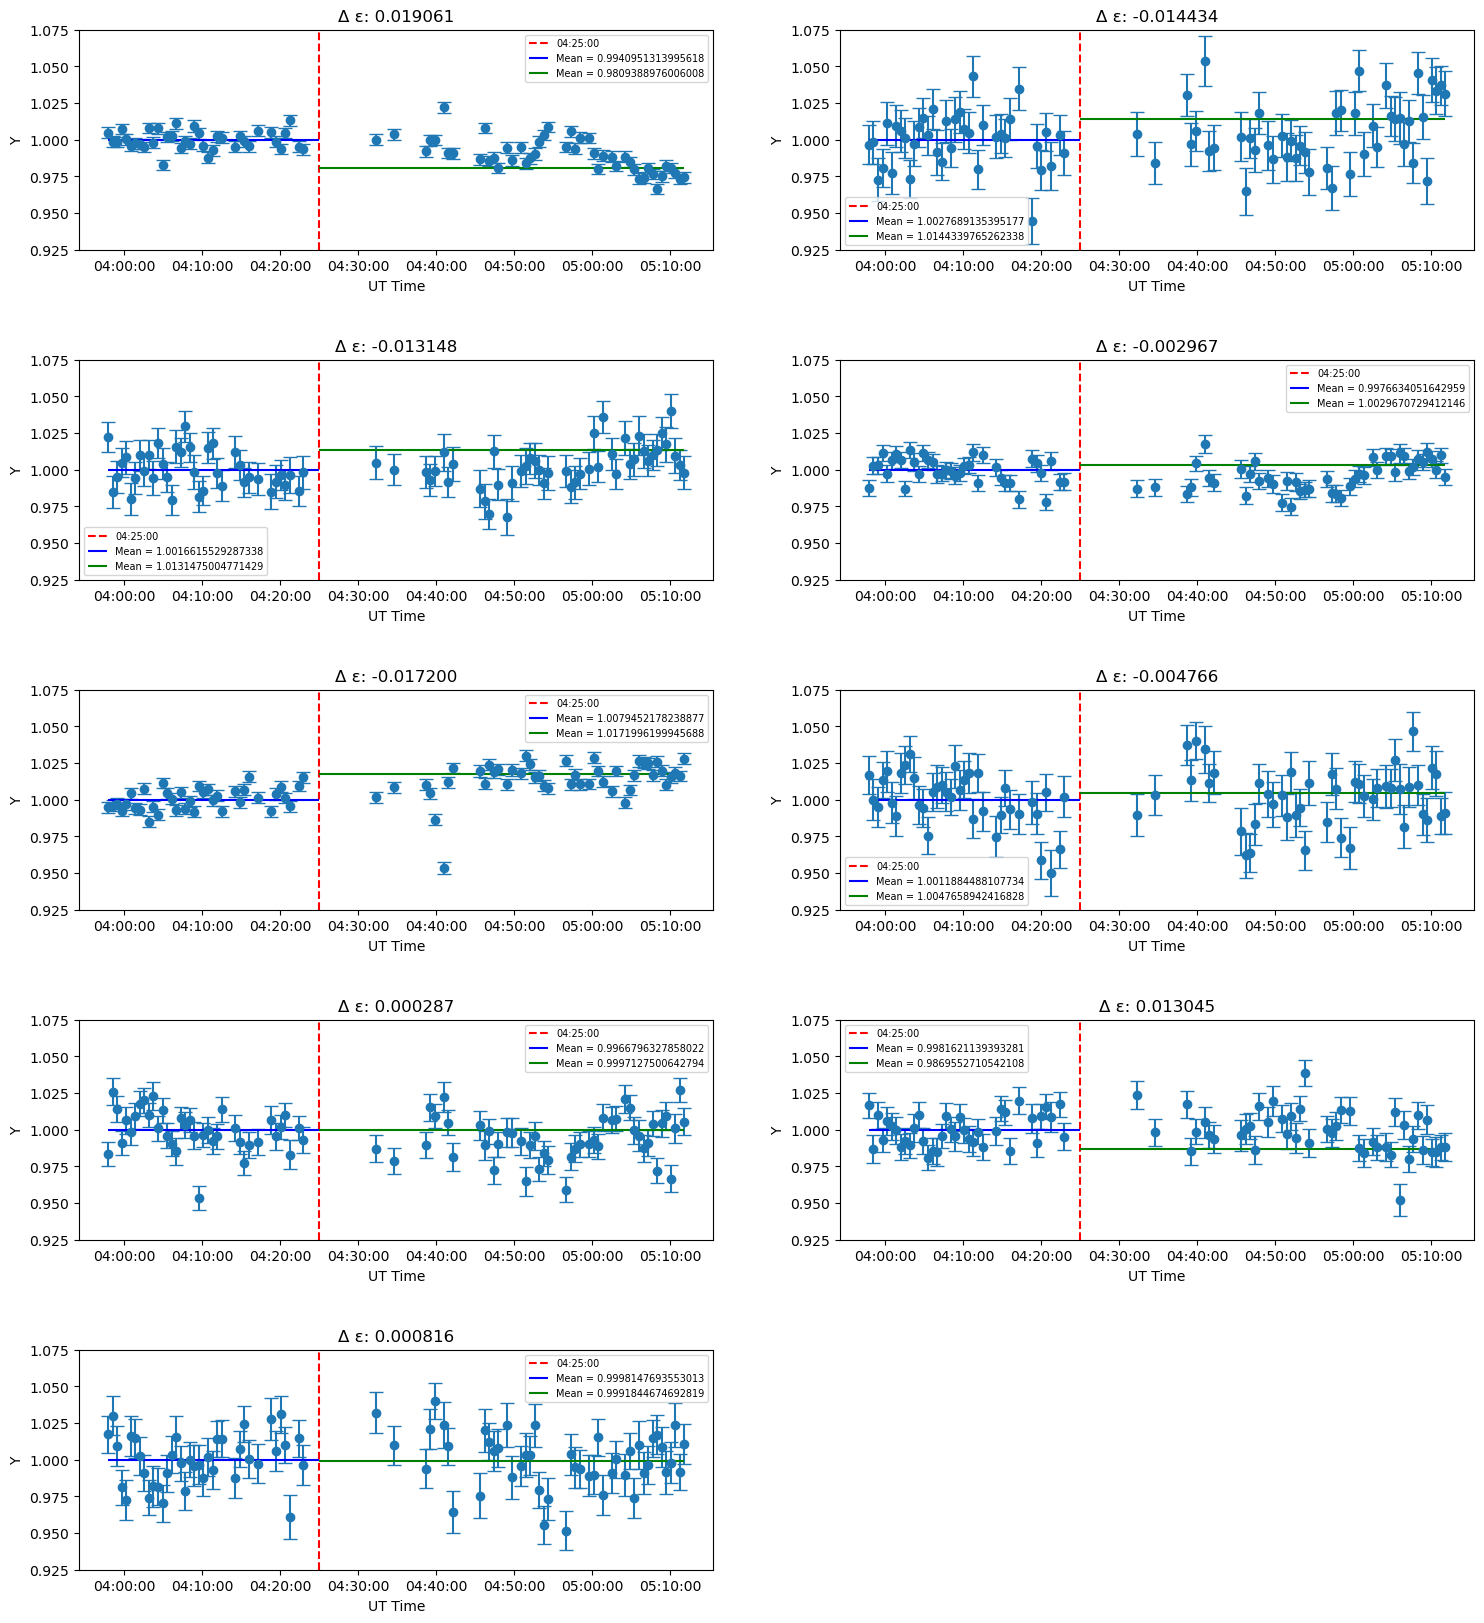

In [249]:
##CALIBRATED BY THE HOST STAR
fig = plt.figure(figsize=(18, 20))  # width, height in inches
plt.subplots_adjust(wspace=.2, hspace=.5)
delta_ref_err=[]
for i in range(len(star_fluxes)):
    star, star_err= star_flux_ratio(star_fluxes[i], star_fluxes_err[i], star_fluxes, star_fluxes_err)
    delta_ref_err.append(np.mean(star_err[:37])-np.mean(star_err[74:]))
    subp = fig.add_subplot(5, 2, i+1)
    subp.errorbar(times_ut, star, yerr=star_err, fmt='o', capsize=5)
    subp.set_ylim(0.925, 1.075)
    subp.set_xlabel('UT Time')
    subp.set_ylabel('Y')
    subp.set_title(f'\u0394 \u03B5: {np.mean(star[:37])-np.mean(star[64:]):.6f}')
    subp.axvline(target_time, color='r', linestyle='--', label='04:25:00')
#line of mean value before the transit
    subp.hlines(np.mean(star[:37]), xmin=times_ut[0], xmax=target_time, color='blue', linestyle='-', label=f'Mean = {np.mean(star)}')
#line of mean value during the transit
    subp.hlines(np.mean(star[64:]), xmin=target_time, xmax=times_ut[-1], color='green', linestyle='-', label=f'Mean = {np.mean(star[64:])}')

    subp.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


    #subp.autofmt_xdate()

    subp.legend(prop={'size': 7})
print(np.mean(delta_ref_err))

In [212]:
star, star_err= star_flux_ratio(star_fluxes[0], star_fluxes_err[0], star_fluxes, starref_fluxes_err)

the difference ε is -0.001639


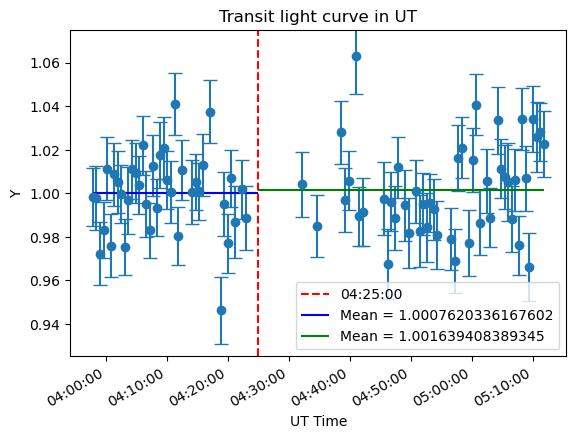

In [214]:
times_ut = [datetime.strptime(t, "%H:%M:%S") for t in frame_times_ut]

#set the target time as "04:25:00"
target_time = datetime.strptime("04:25:00", "%H:%M:%S") 

# print(f'the mean value before the transit is {mean1_nor:.6f}')
# print(f'the mean value during the transit is {mean2_nor:.6f}')
print(f'the difference \u03B5 is {np.mean(starref[:37])-np.mean(starref[38:]):.6f}')
#print(f'the difference \u03B5 error is {np.mean(starref_err[:37])-np.mean(starref_err[38:]):.6f}')

plt.errorbar(times_ut, starref, yerr=starref_err, fmt='o', capsize=5)
plt.ylim(0.925, 1.075)
plt.xlabel('UT Time')
plt.ylabel('Y')
plt.title('Transit light curve in UT')


plt.axvline(target_time, color='r', linestyle='--', label='04:25:00')
#line of mean value before the transit
plt.hlines(np.mean(starref[:37]), xmin=times_ut[0], xmax=target_time, color='blue', linestyle='-', label=f'Mean = {np.mean(starref)}')
#line of mean value during the transit
plt.hlines(np.mean(starref[38:]), xmin=target_time, xmax=times_ut[-1], color='green', linestyle='-', label=f'Mean = {np.mean(starref[38:])}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

-0.0004087690395720765


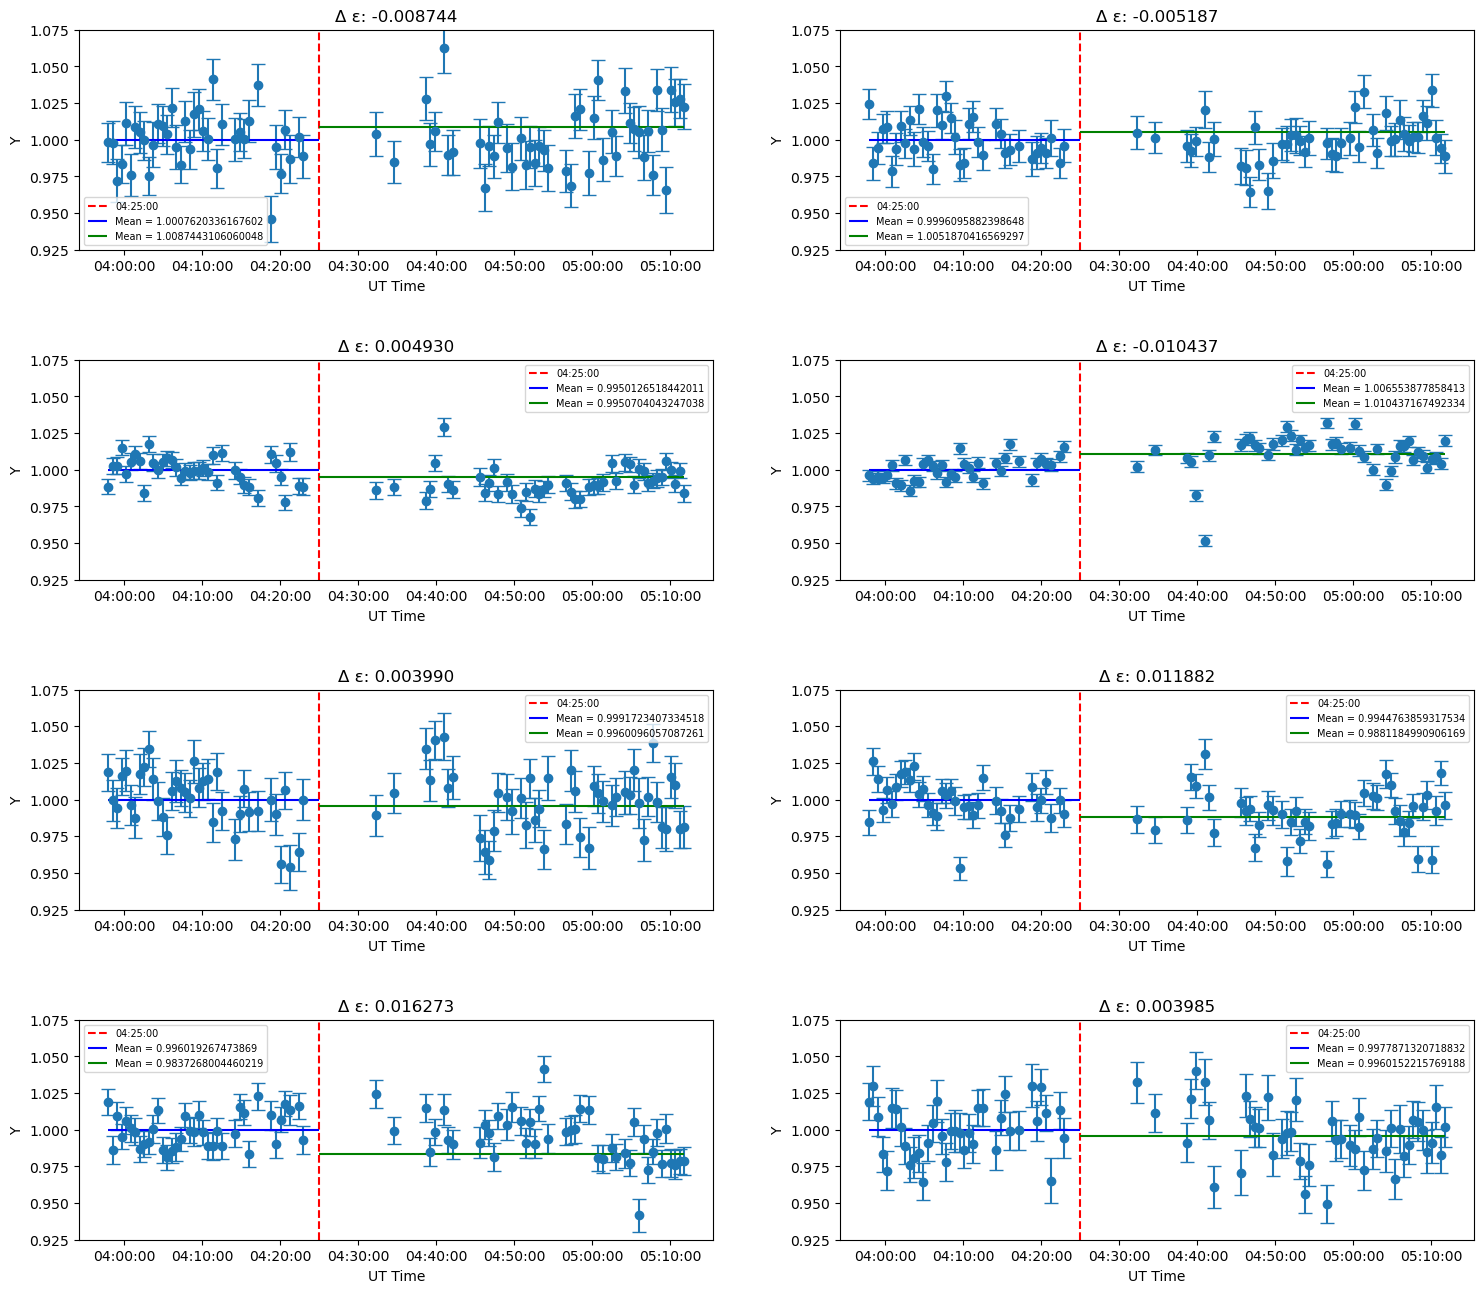

In [236]:
fig = plt.figure(figsize=(18, 20))  # width, height in inches
plt.subplots_adjust(wspace=.2, hspace=.5)
ref_err=[]
for i in range(len(starref_fluxes)):
    starref, starref_err= star_flux_ratio(starref_fluxes[i], starref_fluxes_err[i], starref_fluxes, starref_fluxes_err)
    ref_err.append(np.mean(starref_err[:37])-np.mean(starref_err[74:]))
    subp = fig.add_subplot(5, 2, i+1)
    subp.errorbar(times_ut, starref, yerr=starref_err, fmt='o', capsize=5)
    subp.set_ylim(0.925, 1.075)
    subp.set_xlabel('UT Time')
    subp.set_ylabel('Y')
    subp.set_title(f'\u0394 \u03B5: {np.mean(starref[:37])-np.mean(starref[74:]):.6f}')
    subp.axvline(target_time, color='r', linestyle='--', label='04:25:00')
#line of mean value before the transit
    subp.hlines(np.mean(starref[:37]), xmin=times_ut[0], xmax=target_time, color='blue', linestyle='-', label=f'Mean = {np.mean(starref)}')
#line of mean value during the transit
    subp.hlines(np.mean(starref[74:]), xmin=target_time, xmax=times_ut[-1], color='green', linestyle='-', label=f'Mean = {np.mean(starref[74:])}')

    subp.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


    #subp.autofmt_xdate()

    subp.legend(prop={'size': 7})
print(np.mean(ref_err))

In [237]:
reference_star = []
for i in range(1, nofr+1):  
    reference_star.append(np.array(eval(f'reference_star_{i}')))

In [238]:
ref_flux_ = []

for i in range(nofr):
    ref_flux_.append([]) 

In [239]:
ref_flux_err_ = [] 

for i in range(nofr):
    ref_flux_err_.append([]) 

In [448]:
len(final_ref_flux_[0])

84

In [240]:
ave_ref = []
for i in range(nofr):
    ref_flux_[i]=(reference_star[i]['flux'])
    ref_flux_err_[i]=(reference_star[i]['flux_err'])
    target_average = np.average(reference_star[i]['flux'])
    ave_ref.append(target_average)

In [247]:
final_ref_flux_ = []
final_ref_flux_err_ = []
for i in range(nofr):
    final_ref_flux = ref_flux_[i]/ave_ref[i]
    final_ref_flux_.append(final_ref_flux)
        
    final_ref_flux_err = ref_flux_err_[i]/ave_ref[i]
    final_ref_flux_err_.append(final_ref_flux_err) 

In [299]:
final_host_flux = np.array(host_planet['flux']/np.average(host_planet['flux']))
final_host_flux_err = np.array(host_planet['flux_err']/np.average(host_planet['flux']))


In [280]:
mean_num=[]
mean_dem=[]

for i in range(len(final_ref_flux_[i])):
    a=0.0
    b=0.0
    for j in range(len(final_ref_flux_)):
        a += final_ref_flux_[j][i]/((final_ref_flux_err_[j][i])**2)
        b += 1/((final_ref_flux_err_[j][i])**2)
    mean_num.append(a)
    mean_dem.append(b)

In [527]:
len(mean_num)

84

In [285]:
mean_ref_star=[]
mean_ref_star_err=[]
for i in range(len(mean_num)):
    mean_ref_star.append(mean_num[i]/mean_dem[i])
    mean_ref_star_err.append(math.sqrt(1/mean_dem[i]))

In [307]:
r_flux=[]
r_flux_err=[]
for i in range(len(mean_ref_star)):
    r_flux.append(final_host_flux[i]/mean_ref_star[i])

In [368]:
np.mean(r_flux[38:])

0.9973251657068845

In [376]:
rf_flux=r_flux/np.mean(r_flux[:37])
rf_flux_err=final_host_flux_err/np.mean(r_flux[:37])

In [377]:
rf_flux_err

array([0.00355183, 0.00371904, 0.00369098, 0.00350331, 0.00371606,
       0.00368838, 0.00369267, 0.00363554, 0.00354873, 0.00350302,
       0.00378462, 0.00356905, 0.00356447, 0.00354266, 0.00355966,
       0.003793  , 0.00344845, 0.00361691, 0.00349744, 0.00380052,
       0.00364213, 0.00353794, 0.00362547, 0.00362074, 0.00353006,
       0.00359667, 0.00370532, 0.00349726, 0.00349251, 0.00362549,
       0.00367461, 0.00373642, 0.00372024, 0.00354403, 0.00351849,
       0.00374892, 0.00355211, 0.00372186, 0.00374005, 0.00364007,
       0.0036405 , 0.00369157, 0.0035107 , 0.00380483, 0.00353333,
       0.00359029, 0.00377977, 0.00365748, 0.00353405, 0.00370967,
       0.00358327, 0.0037875 , 0.0038663 , 0.00367036, 0.00373526,
       0.00362173, 0.00382876, 0.00348508, 0.00343089, 0.00355991,
       0.00346164, 0.00373095, 0.0037237 , 0.00359793, 0.00359964,
       0.00365246, 0.00355628, 0.00369342, 0.00366366, 0.00352324,
       0.00377404, 0.00351024, 0.00368899, 0.0039274 , 0.00374

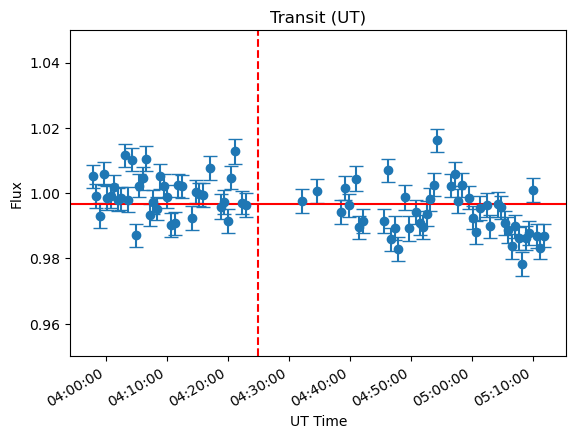

In [378]:
plt.errorbar(times, rf_flux, yerr=rf_flux_err, fmt='o', capsize=5)
plt.axvline(x=datetime.strptime("04:25:00", "%H:%M:%S"), color='red', linestyle='--', label="04:25:00")
plt.axhline(y=np.mean(rf_flux), color='r', linestyle='-')
plt.xlabel('UT Time')
plt.ylabel('Flux')
plt.ylim(0.95,1.05)
plt.title('Transit (UT)')

# Format the x-axis to display HH:MM:SS
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate date labels to avoid overlap
plt.gcf().autofmt_xdate()

plt.show()

In [242]:
#final_ref_flux_ = []

# for i in range(nofr):
#     final_ref_flux_.append([]) 

In [243]:
#final_ref_flux_err_ = []

# for i in range(nofr):
#     final_ref_flux_err_.append([]) 

In [306]:
final_host_flux_err

array([0.00356427, 0.00373206, 0.00370391, 0.00351557, 0.00372908,
       0.0037013 , 0.0037056 , 0.00364827, 0.00356116, 0.00351529,
       0.00379788, 0.00358155, 0.00357695, 0.00355506, 0.00357213,
       0.00380628, 0.00346052, 0.00362958, 0.00350968, 0.00381383,
       0.00365488, 0.00355033, 0.00363817, 0.00363342, 0.00354242,
       0.00360927, 0.00371829, 0.0035095 , 0.00350474, 0.00363819,
       0.00368748, 0.0037495 , 0.00373327, 0.00355644, 0.00353081,
       0.00376205, 0.00356455, 0.00373489, 0.00375315, 0.00365281,
       0.00365325, 0.0037045 , 0.003523  , 0.00381815, 0.0035457 ,
       0.00360286, 0.00379301, 0.00367029, 0.00354642, 0.00372266,
       0.00359582, 0.00380077, 0.00387984, 0.00368322, 0.00374834,
       0.00363441, 0.00384217, 0.00349728, 0.00344291, 0.00357238,
       0.00347377, 0.00374402, 0.00373674, 0.00361053, 0.00361225,
       0.00366525, 0.00356873, 0.00370636, 0.00367649, 0.00353558,
       0.00378725, 0.00352253, 0.00370191, 0.00394116, 0.00376

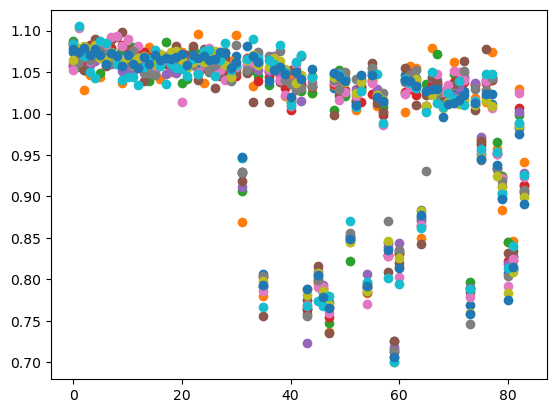

In [297]:
plt.scatter(np.arange(len(final_ref_flux_[0])), final_host_flux)
plt.scatter(np.arange(len(final_ref_flux_[0])), final_ref_flux_[0])
plt.scatter(np.arange(len(final_ref_flux_[1])), final_ref_flux_[1])
plt.scatter(np.arange(len(final_ref_flux_[2])), final_ref_flux_[2])
plt.scatter(np.arange(len(final_ref_flux_[3])), final_ref_flux_[3])
plt.scatter(np.arange(len(final_ref_flux_[4])), final_ref_flux_[4])
plt.scatter(np.arange(len(final_ref_flux_[5])), final_ref_flux_[5])
plt.scatter(np.arange(len(final_ref_flux_[6])), final_ref_flux_[6])
plt.scatter(np.arange(len(final_ref_flux_[7])), final_ref_flux_[7])
plt.scatter(np.arange(len(final_ref_flux_[8])), final_ref_flux_[8])
plt.scatter(np.arange(len(final_ref_flux_[9])), final_ref_flux_[9])

In [279]:
len(final_ref_flux_[0])

84

In [322]:
final_host_flux_err

array([0.00356427, 0.00373206, 0.00370391, 0.00351557, 0.00372908,
       0.0037013 , 0.0037056 , 0.00364827, 0.00356116, 0.00351529,
       0.00379788, 0.00358155, 0.00357695, 0.00355506, 0.00357213,
       0.00380628, 0.00346052, 0.00362958, 0.00350968, 0.00381383,
       0.00365488, 0.00355033, 0.00363817, 0.00363342, 0.00354242,
       0.00360927, 0.00371829, 0.0035095 , 0.00350474, 0.00363819,
       0.00368748, 0.0037495 , 0.00373327, 0.00355644, 0.00353081,
       0.00376205, 0.00356455, 0.00373489, 0.00375315, 0.00365281,
       0.00365325, 0.0037045 , 0.003523  , 0.00381815, 0.0035457 ,
       0.00360286, 0.00379301, 0.00367029, 0.00354642, 0.00372266,
       0.00359582, 0.00380077, 0.00387984, 0.00368322, 0.00374834,
       0.00363441, 0.00384217, 0.00349728, 0.00344291, 0.00357238,
       0.00347377, 0.00374402, 0.00373674, 0.00361053, 0.00361225,
       0.00366525, 0.00356873, 0.00370636, 0.00367649, 0.00353558,
       0.00378725, 0.00352253, 0.00370191, 0.00394116, 0.00376

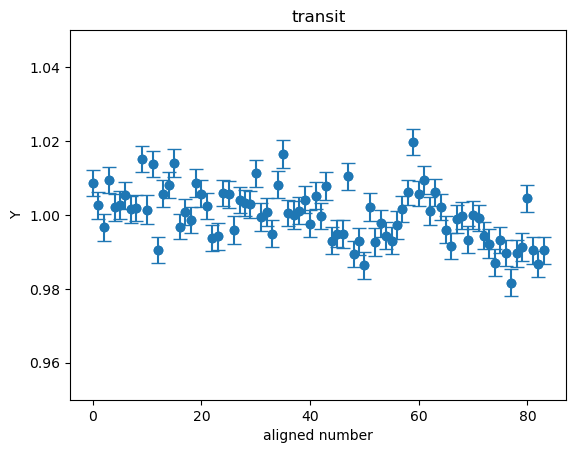

In [319]:
plt.scatter(np.arange(len(r_flux)), r_flux)  
plt.errorbar(np.arange(len(r_flux)), r_flux, yerr=final_host_flux_err, fmt='o', capsize=5)
plt.ylim(0.95,1.05)
plt.xlabel('aligned number')
plt.ylabel('Y')
plt.title('transit')

plt.show()

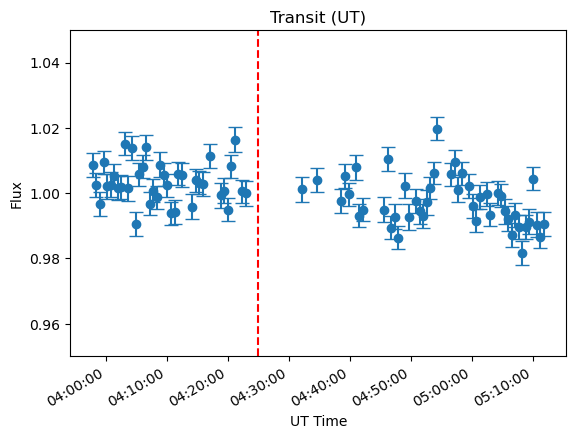

In [324]:
# Plot the updated graph
plt.errorbar(times, r_flux, yerr=final_host_flux_err, fmt='o', capsize=5)
plt.axvline(x=datetime.strptime("04:25:00", "%H:%M:%S"), color='red', linestyle='--', label="04:25:00")
plt.xlabel('UT Time')
plt.ylabel('Flux')
plt.ylim(0.95,1.05)
plt.title('Transit (UT)')

# Format the x-axis to display HH:MM:SS
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate date labels to avoid overlap
plt.gcf().autofmt_xdate()

plt.show()

In [113]:
# mean_ref = []
# for i in range(nofr):
#     target_ref_star = reference_star[i]
#     for j in range(len(reference_star[i])):
#         target_flux = target_ref_star[j][3]
#         ref_flux_[i].append(target_flux)
        
#         target_flux_err = target_ref_star[j][4]
#         ref_flux_err_[i].append(target_flux_err)
        
#     target_mean = np.mean(ref_flux_[i])
#     mean_ref.append(target_mean)

In [86]:
# final_ref_flux_ = []

# for i in range(nofr):
#     final_ref_flux_.append([]) 

In [87]:
# final_ref_flux_err_ = []

# for i in range(nofr):
#     final_ref_flux_err_.append([]) 

In [88]:
# for i in range(nofr):
#     needed_ref_flux = ref_flux_[i]
#     needed_ref_flux_err = ref_flux_err_[i]
#     for j in range(len(reference_star_1)):
#         final_ref_flux = needed_ref_flux[j]/mean_ref[i]
#         final_ref_flux_[i].append(final_ref_flux)
        
#         final_ref_flux_err = needed_ref_flux_err[j]/mean_ref[i]
#         final_ref_flux_err_[i].append(final_ref_flux_err) 

In [89]:
mu_ref_up = []
mu_ref_down = []

for j in range(len(reference_star_1)):
    a = 0
    b = 0
    for i in range(nofr):
        a += float(final_ref_flux_[i][j])/((float(final_ref_flux_err_[i][j]))**2)
        b += 1/((float(final_ref_flux_err_[i][j]))**2)
    
    mu_ref_up.append(a)
    mu_ref_down.append(b)

In [90]:
mu = []
delta_ref = []

for i in range(len(reference_star_1)):
    c = mu_ref_up[i]/mu_ref_down[i]
    d = math.sqrt(1/mu_ref_down[i])
    mu.append(c)
    delta_ref.append(d)

In [283]:
mu_ref_down

[271272.98963350884,
 240055.93774698224,
 243097.22531420342,
 281995.53813857253,
 240550.67442212827,
 244862.1641641669,
 244446.67585839782,
 254695.89498019154,
 270432.87282888684,
 282590.5555202401,
 228998.1714659665,
 268737.7819407168,
 264714.5824476615,
 272243.09643286484,
 268902.836067242,
 229138.70218473708,
 290262.8386547477,
 256513.90783371116,
 280050.74022640375,
 227599.2105934676,
 262786.629971092,
 271895.51542382874,
 254191.35630942936,
 254533.08764047644,
 274719.6988226149,
 261508.17162689846,
 240352.21244149643,
 281100.4771253481,
 281901.21835004986,
 254636.34280452656,
 248157.90084366006,
 228699.67034583204,
 238770.54439538714,
 269323.5063026125,
 277440.8664478841,
 222081.50605661687,
 268095.8540884733,
 238302.5356225326,
 235150.2948828432,
 251597.6533980424,
 248766.79782570372,
 243020.01427632317,
 275085.4257315747,
 212853.4144295668,
 269259.07639327634,
 243729.2962612981,
 215669.37753124538,
 233038.08001699747,
 268008.470459

In [170]:
host_planet_flux = host_planet['flux']
host_planet_err = host_planet['flux_err']

    
host_mean = np.mean(host_planet_flux)

In [173]:
host = []
host_err = []

for i in range(len(reference_star_1)):
    e = host_planet_flux[i]/host_mean
    host.append(e)
    f = host_planet_err[i]/host_mean
    host_err.append(f)

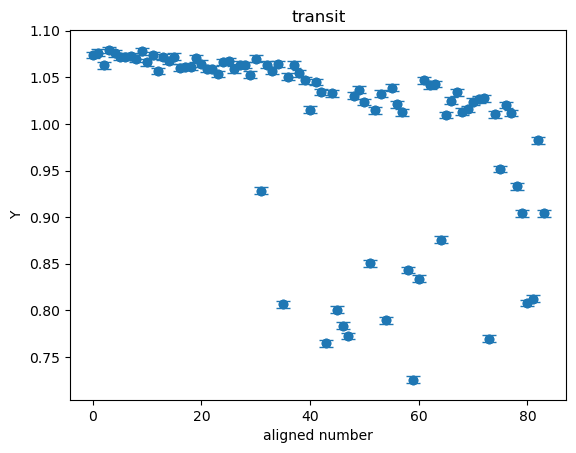

In [175]:
x = np.arange(len(fluxes)) 
y = host   

plt.scatter(x, y)  
plt.errorbar(x, y, yerr=host_err, fmt='o', capsize=5)

plt.xlabel('aligned number')
plt.ylabel('Y')
plt.title('transit')

plt.show()

In [176]:
r = []
r1 = []

for i in range(len(reference_star_1)):
    g = host[i]/mu[i]
    g1 = final_ref_flux[0][i]/mu[i]
    r1
    r.append(g)

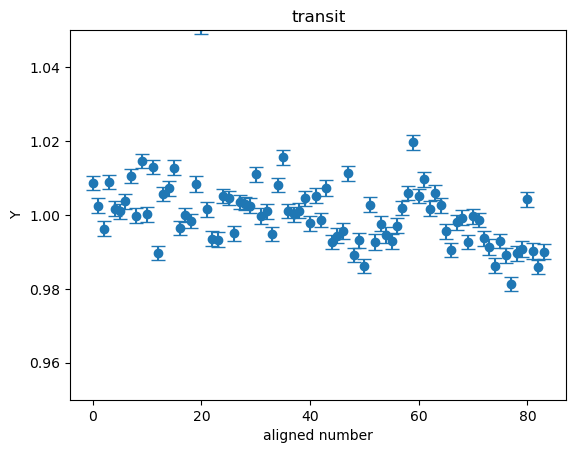

In [320]:

y = r   

#plt.scatter(x, y)  
plt.errorbar(x, y, yerr=delta_ref, fmt='o', capsize=5)
plt.ylim(0.95,1.05)
plt.xlabel('aligned number')
plt.ylabel('Y')
plt.title('transit')

plt.show()

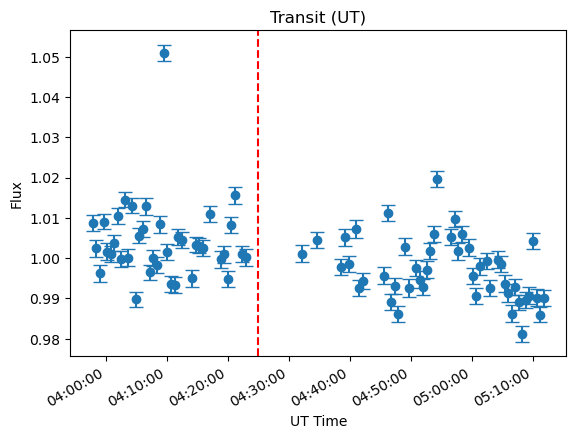

In [601]:
# Plot the updated graph
plt.errorbar(times, y, yerr=delta_ref, fmt='o', capsize=5)
plt.axvline(x=datetime.strptime("04:25:00", "%H:%M:%S"), color='red', linestyle='--', label="04:25:00")
plt.xlabel('UT Time')
plt.ylabel('Flux')
plt.title('Transit (UT)')

# Format the x-axis to display HH:MM:SS
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate date labels to avoid overlap
plt.gcf().autofmt_xdate()

plt.show()

In [264]:
def align_images(images, star_coords, center_coords):
    aligned_images = []

    for img, (star_x, star_y) in zip(images, star_coords):
        x_offset = center_coords[0] - star_x
        y_offset = center_coords[1] - star_y
        aligned_img = shift(img, shift=(y_offset, x_offset), mode='nearest')
        aligned_images.append(aligned_img)

    return aligned_images

In [273]:
def save_aligned_images(aligned_images, ownerpath):
    for i, aligned_img in enumerate(aligned_images):
        hdu = fits.PrimaryHDU(aligned_img)
        hdu.writeto(f'{ownerpath}/Lab 2/Aligned Images/aligned_HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits', overwrite=True)

In [274]:
# Define paths
input_directory = f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/'
output_directory = f'{ownerpath}/Lab 2/Aligned Images/'

# List of your FITS files with full paths
filenames = [f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits' for i in [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31,
    33, 37, 38, 39, 42, 43, 59, 63, 70, 71, 72, 75, 84, 85,
    86, 89, 91, 93, 94, 95, 102, 103, 104, 107, 108, 109,
    111, 112, 114, 115, 116, 118, 120, 121, 122, 126
]]


# Star coordinates in each image
star_coords = [
    (493.338, 609.667), (490.2, 613.8), (501, 595.338), (498.6, 600.6),
    (496.2, 604.2), (513, 577.338), (540, 535.338), (537.2, 539.667),
    (533.338, 543.338), (530.5, 548.338), (528, 552.2), (524.667, 556.3),
    (522.2, 560.5), (518.338, 564.667), (516.3, 568.338), (513, 572.2),
    (510.5, 575.5), (507.2, 579.667), (503.338, 583.5), (501, 587.2),
    (489, 590.5), (494.667, 594.667), (492.2, 598.338), (488.338, 602.2),
    (485.5, 606.3), (482.2, 610.5), (473, 621.3), (470.5, 624.667),
    (466.338, 628.5), (463.338, 632.2), (457.2, 639.667), (445, 653.338),
    (441.667, 657.338), (438.667, 660.5), (429.667, 670.667), (426, 674.338),
    (410, 671.667), (396.833, 683.5), (438, 605.5), (434.667, 608),
    (431.3, 610.5), (419.667, 619.667), (386.3, 644.667), (382.167, 647.2),
    (378.833, 650.5), (368, 658), (359.667, 663.883), (352.2, 669.667),
    (348.833, 673), (344.667, 675.5), (316, 696.3), (312.2, 698.833),
    (308.5, 701.883), (394.3, 561.833), (443.833, 485.5), (492.2, 408.833),
    (484.667, 413), (481.3, 414.667), (473, 418.833), (469.667, 421.3),
    (466.3, 423), (458, 427.2), (450.5, 432.2), (446.3, 433.833),
    (442.2, 436.3), (425.5, 44.667)]

In [275]:
# Center of the image
center_coords = (512, 512)  # For a 1024x1024 image

# Function to load images
def load_fits_images(filepaths):
    return [fits.getdata(fp) for fp in filepaths]

# Function to align images
def align_images(images, star_coords, center_coords):
    aligned_images = []
    for img, (star_x, star_y) in zip(images, star_coords):
        x_offset = center_coords[0] - star_x
        y_offset = center_coords[1] - star_y
        aligned_img = shift(img, shift=(y_offset, x_offset), mode='nearest')
        aligned_images.append(aligned_img)
    return aligned_images

# Function to save aligned images
def save_aligned_images(aligned_images, output_directory, base_name):
    for i, aligned_img in enumerate(aligned_images):
        hdu = fits.PrimaryHDU(aligned_img)
        hdu.writeto(os.path.join(output_directory, f"{base_name}.{i}.fits"), overwrite=True)

# Load images
filepaths = [os.path.join(input_directory, fname) for fname in filenames]
images = load_fits_images(filepaths)

# Align images
aligned_images = align_images(images, star_coords, center_coords)

# Save aligned images
#save_aligned_images(aligned_images, output_directory, "aligned_HAT_P_16_VISIBLE_LIGHT_20S_")

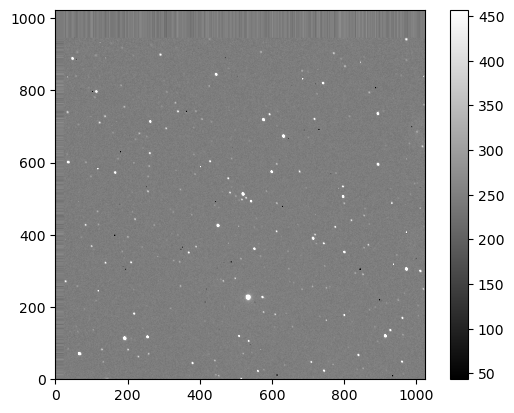

In [283]:
plt.imshow(aligned_images[20], cmap='gray', origin='lower', vmin=np.mean(aligned_images[0])-np.std(aligned_images[0]), vmax=np.mean(aligned_images[0])+np.std(aligned_images[0]))
plt.colorbar()
plt.show()